# Components

# 1.Chat Model

In [ ]:
!pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 27.6 MB/s eta 0:00:00


In [ ]:
import getpass
import os

if not os.environ.get("GROQ_API_KEY"):
  os.environ["GROQ_API_KEY"] = getpass.getpass("Enter API key for Groq: ")

from langchain_groq import ChatGroq

llm = ChatGroq(model="llama3-8b-8192")

Enter API key for Groq: ··········


# 2.Embeddings Model

In [ ]:
!pip install -qU langchain-huggingface

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# 3.Vector Store

In [ ]:
!pip install -qU langchain-pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.8/244.8 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone, ServerlessSpec

pc = Pinecone(api_key="pcsk_cMxH1_KMbU8bUVJhx98ZoU2rHHWKPBb3eFCydCsSarY2dGp37ySkubuEAkF9BU2EJJyWP")
index_name = "rag-workshop"
dimension = 768  # Replace with your model's embedding size
metric = "cosine"  # Can also be "dotproduct" or "euclidean"
# Check existing indexes
existing_indexes = pc.list_indexes()  # Returns metadata for indexes
existing_index_names = {idx["name"] for idx in existing_indexes}

print("Existing Indexes: ", existing_index_names)
# Check if the index exists
if index_name not in existing_index_names:
    # Create a new index if it doesn't exist
    print(f"Index '{index_name}' does not exist. Creating a new one...")
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric=metric,
        spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1",
      ),
      deletion_protection="disabled"
    )
else:
    print(f"Index '{index_name}' already exists.")

index = pc.Index(index_name)

vector_store = PineconeVectorStore(embedding=embeddings, index=index)

Existing Indexes:  {'rag-workshop', 'llama-2-rag-test'}
Index 'rag-workshop' already exists.


# Installations

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

# Retrival (with LangChain tool)

Leveraging tool-calling to interact with a retrieval step has another benefit, which is that the query for the retrieval is generated by our model. This is especially important in a conversational setting, where user queries may require contextualization based on the chat history. For instance, consider the following exchange:

**Human**: "What is Task Decomposition?"

**AI**: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."

**Human**: "What are common ways of doing it?"

In [ ]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

# Generation

In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    print("Generated Response: ", response)
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    print("Answer Response: ", response)
    return {"messages": [response]}

# LangGraph

Our graph will consist of **three nodes**:

1.   A node that fields the **user input**,
either generating a query for the retriever or responding directly.

2. A node for the **retriever tool** that executes the retrieval step.

3. A node that generates the **final response** using the retrieved context.

We build them below. Note that we leverage another pre-built LangGraph component, ToolNode, that executes the tool and adds the result as a ToolMessage to the state.

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

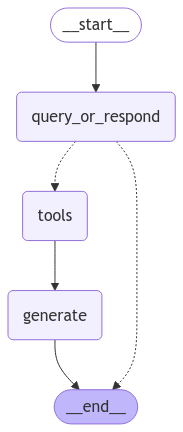

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# LangSmith

Many of the applications you build with LangChain will contain multiple steps with multiple invocations of LLM calls. As these applications get more and more complex, it becomes crucial to be able to inspect what exactly is going on inside your chain or agent.
https://smith.langchain.com/
LangSmith, after you sign up at the link above, make sure to set your environment variables to start **logging traces**:

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
if not os.environ.get("LANGCHAIN_API_KEY"):
    os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter LangSmith API Key :")

Enter LangSmith API Key :··········


# Memory for Chat history

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

# Application

In [ ]:
user_input = "Can you list some common ways of doing it?"# @param {"type":"string","placeholder":"Enter query here..."}

for step in graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Can you list some common ways of doing it?


Generated Response:  content='Here are some common ways to do it:\n\nRetrieve the information related to a query.\n\n{\n"tool_calls": [\n{\n"id": "pending",\n"type": "function",\n"function": {\n"name": "retrieve"\n},\n"parameters": {\n"query": "some query value"\n}\n}\n]\n}</tool-use>' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 64, 'prompt_tokens': 1837, 'total_tokens': 1901, 'completion_time': 0.053333333, 'prompt_time': 0.225679599, 'queue_time': -0.599788305, 'total_time': 0.279012932}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_6a6771ae9c', 'finish_reason': 'stop', 'logprobs': None} id='run-d436f384-6884-48e3-bfc8-7c8d8e1b96aa-0' usage_metadata={'input_tokens': 1837, 'output_tokens': 64, 'total_tokens': 1901}
================================== Ai Message ==================================

Here are some common ways to do it:

Retrieve the information related to a query.

{
"tool_calls": [
{
"id": "pending",
"type": "function",
"funct

# Agents (Multi-step retreival)

In [ ]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

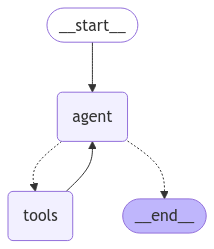

In [ ]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================

The standard method for Task Decomposition is the Work Breakdown Structure (WBS). It's a hierarchical decomposition of the task into smaller, more manageable tasks. The WBS is a tree-like structure that starts with the overall goal or objective, and then breaks down into smaller tasks, subtasks, and even smaller sub-subtasks, until the task is decomposed into manageable pieces.

Here's a general outline of the WBS process:

1. Define the project goal or objective.
2. Identify the major tasks required to achieve the goal.
3. Decompose each major task into smaller subtasks.
4. Decompose each subtask into even smaller sub-subtasks, and so on.
5. Continue decomposing until the tasks are small enough to be manag